# Multivariate time series prediction using MLP in Keras 

Borrowed from [here](https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/).

## One step predictions

### Univariate

As input we have a sequence of data: `[10, 20, 30, 40, 50, ...]`.

Technically, the model will view each time step as a separate feature instead of separate time steps.

We almost always have multiple samples, therefore, the model will expect the input component of training data to have the dimensions or shape:

`[samples, features]` e.g.:  
```
X = [[10, 20, 30],
     [20, 30, 40],
     [30, 40, 50],
     ...]
```  
and the output:
```
y = [40,
     50,
     60,
     ...]
```

### Multivariate (one output)

In this case, we have many parallel time series where each of them is traditionally represented as column:

```
[[ 10  15  25],
 [ 20  25  45],
 [ 30  35  65],
 [ 40  45  85],
 ...]
 ```
 
 Our transformed input/output for one sample will look like:
 
```
X[0] = [[10, 15],
       [20, 25],
       [30, 35]]
```  
```
y[0] = 65
```

Note that the choice of the input sequence length has an impact on how many outputs will be taken into account!

In general, our input is of shape `[time_series, samples, features]`. Therefore we have two possibilities:

1. in order to feed it into a single MLP, we need to concatenate the last two dimensions: `X[0] = [10, 15, 20, 25, 30, 35]`:
    ```python
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    ```
2. Alternatively, we can create so-called multi-headed MLP using Keras functional API. 
    - Each input series can be handled by a separate MLP.
    - The output of each of these submodels can be combined before a prediction is made for the output sequence.
    ```python
    # separate input data
    n_steps = X.shape[1]
    X1 = X[:, :, 0]
    X2 = X[:, :, 1]
    # first input model
    visible1 = Input(shape=(n_steps,))
    dense1 = Dense(100, activation='relu')(visible1)
    # second input model
    visible2 = Input(shape=(n_steps,))
    dense2 = Dense(100, activation='relu')(visible2)
    # merge input models
    merge = concatenate([dense1, dense2])
    output = Dense(1)(merge)
    model = Model(inputs=[visible1, visible2], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit([X1, X2], y, epochs=2000, verbose=0)
    ```
    
### Multivariate (many outputs)

An alternate time series problem is the case where there are multiple parallel time series and a value must be predicted for each. Let's use the same dataset:
```
[[ 10  15  25],
 [ 20  25  45],
 [ 30  35  65],
 [ 40  45  85],
 [ 50  55  105],
 ...]
```
Then:  
```
X[0] = [[10, 15, 25],
       [20, 25, 45],
       [30, 35, 65]]
y[0] = [40, 45, 85]
```
```
X[1] = [[20, 25, 45],
       [30, 35, 65],
       [40 45 85]]
y[1] = [50, 55, 105]
...
```
We can use the two above options with little changes:
   
1. Replace `model.add(Dense(1))` with `model.add(Dense(Y.shape[1))`
2. A few modifications are required:
    - add another layers `X3`, `visible3` and `Dense3` and change the code accordingly
    - replace `output = Dense(1)(merge)` with `output = Dense(Y.shape[1))(merge)`
    
Or:    

3. Multi-output MLP model:
    ```python
    # flatten input
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    # separate output
    y1 = y[:, 0].reshape((y.shape[0], 1))
    y2 = y[:, 1].reshape((y.shape[0], 1))
    y3 = y[:, 2].reshape((y.shape[0], 1))
    # define model
    visible = Input(shape=(n_input,))
    dense = Dense(100, activation='relu')(visible)
    # define output 1
    output1 = Dense(1)(dense)
    # define output 2
    output2 = Dense(1)(dense)
    # define output 3
    output3 = Dense(1)(dense)
    # tie together
    model = Model(inputs=visible, outputs=[output1, output2, output3])
    model.compile(optimizer='adam', loss='mse')
    ```
4. Multi-headed multi-output MLP 
    - combination of 2. and 3.
   
Note that:
- both 1. and 3. require concatenation of the input series
- in 3. the model outputs three distinct values for every series
- in 2. we treat the input series as independent, add dependency later and predict one output with three values  
- in 4. we treat the input series as independent and outputs three distinct values

## Multi-Step predictions

Predict more than one step ahead.

### Univariate

As above but we need to change `y` e.g.

For `[samples, features]` of the form:  
```
X = [[10, 20, 30],
     [20, 30, 40],
     [30, 40, 50],
     ...]
```  
we need:
```
y = [40, 50,
     50, 60,
     60, 70,
     ...]
```

The output layer shall be modified accordingly to return two (or more) values instead of just one.

### Multivariate (one output)

Again, for `X` of the form:

```
[[ 10  15  25],
 [ 20  25  45],
 [ 30  35  65],
 [ 40  45  85],
 [ 50, 55, 105],
 ...]
 ```
 
We require:
 
```
X[0] = [[10, 15],
       [20, 25],
       [30, 35]]
```  
```
y[0] = [65, 85]
```

The output layer shall be modified accordingly to return two (or more) values instead of just one.


### Multivariate (many outputs)

For `X` as above:

```
X[0] = [[10, 15, 25],
       [20, 25, 45],
       [30, 35, 65]]
       
y[0] = [[40, 45, 85]
       [50, 55, 105]]
...
```

- For options 1. and 2. the output layer shall be modified accordingly to return `2 * n_features` (or more) values instead of just one (i.e. in the concatenated form). 
- For options 3. and 4. the model shall predict 2 (or more) values separately from each output layer.


In [1]:
import os
import sys
import joblib
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from pathlib import Path
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.layers.merge import concatenate
from tensorflow.keras.regularizers import L1L2
from sklearn.metrics import mean_squared_error

In [2]:
MODULE_PATH = os.path.abspath('/storage/pszczerbiak/microbiome_interactions_project/')  # TODO load from CONFIG file
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

In [3]:
from utils.transformers import CLRTransformer, Log1pMinMaxScaler, IdentityScaler
from utils.measures import calculate_f1score, calculate_spearman, calculate_nrmse, inter_dissimilarity, intra_dissimilarity

## Load data

In [4]:
dname = 'donorA'  # dataset name
ref_dname = 'donorB'  # reference (test) dataset name
sname = 'log1pminmax' # scaler name e.g. 'id', 'clr_None_True', 'log1pminmax'

DATA_PATH = Path("/storage/zkarwowska/microbiome-interactions/datasets/processed/ready_datasets_transformed/common")  # TODO load from CONFIG file
dataset = pd.read_csv(DATA_PATH / f"{dname}_{sname}.csv", index_col=0)
dataset_original = pd.read_csv(DATA_PATH / f"{dname}.csv", index_col=0)
ref_dataset_original = pd.read_csv(DATA_PATH / f"{ref_dname}.csv", index_col=0)
scaler = joblib.load(DATA_PATH / f'scaler_{dname}_{sname}.obj')

#### Additional parameters for `scaler.inverse_transorm()`

For `clr` transformations we don't want to remove pseudocounts since it requires knowledge where initial 0's are located (there are not always known)

In [5]:
sparams = {'remove_pseudocounts': False} if sname.startswith('clr') else {}

#### Reference dataset may have different number of rows but the same number of columns

In [6]:
dataset.shape, dataset_original.shape, ref_dataset_original.shape

((365, 166), (365, 166), (253, 166))

In [7]:
assert dataset.shape == dataset_original.shape
assert dataset.shape[1] == ref_dataset_original.shape[1]

In [8]:
dataset.iloc[:5, :1]

,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTG
0,0.888139
1,0.859701
2,0.891279
3,0.891279
4,0.941755


In [9]:
dataset_original.iloc[:5, :1]

,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTG
0,2995.0
1,2555.0
2,3048.0
3,3048.0
4,4041.0


In [10]:
ref_dataset_original.iloc[:5, :1]

,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTG
0,2697.0
1,2959.0
2,3332.0
3,2706.0
4,2894.0


## Plot data

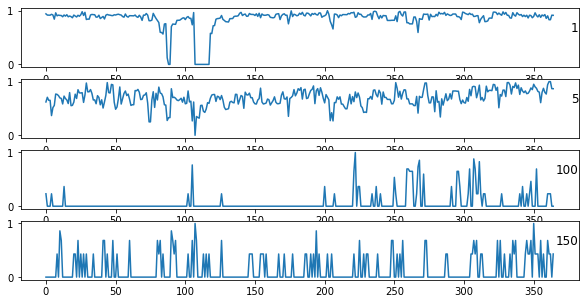

In [11]:
columns = [1, 5, 100, 150]
plt.figure(figsize=(10, 5))
for i, column in enumerate(columns):
    plt.subplot(len(columns), 1, i+1)
    plt.plot(dataset.iloc[:, column])
    # plt.plot(dataset_original.iloc[:, column])
    plt.title(column, y=0.5, loc='right')
plt.show()

## Data Preparation

The first step is to prepare the dataset for ML predictions. This involves framing the dataset as a supervised learning problem and normalizing the input variables (already done above).

### Convert series to supervised learning

**Assumption**  
We believe that predicitions in subsequent time step depend on values from **the last `STEPS_IN` time steps only**. 

Therefore:  

Number of samples = `dataset.shape[0] // STEPS_IN` (we need to throw last couple of timesteps)  
Number of input timesteps = `STEPS_IN`  
Number of output timesteps = `STEPS_OUT`  
Number of input features = `dataset.shape[1]`  
Number of output features = `dataset.shape[1]`

In [12]:
STEPS_IN = 1
STEPS_OUT = 1

In [13]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Transform multivariate time series (with rows as time steps
    and columns as features) into supervised dataset.

    n_in: number of time steps used for prediction
    n_out: number of time steps to be predicted.

    If n_in > 1, the result dataframe contains some redundant
    information (some columns, e.g. var(t-2) and var(t-1), are the
    the same but shifted by one or more rows).
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:
reframed = series_to_supervised(dataset.values, STEPS_IN, STEPS_OUT)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

In [15]:
dataset.shape

(365, 166)

In [16]:
reframed.shape

(364, 332)

In [17]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var157(t),var158(t),var159(t),var160(t),var161(t),var162(t),var163(t),var164(t),var165(t),var166(t)
1,0.888139,0.940727,0.840276,0.844679,0.560487,0.621064,0.741032,0.888365,0.708408,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.859701,0.918044,0.836671,0.798312,0.641647,0.707893,0.834422,0.780228,0.731369,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.891279,0.916305,0.831780,0.747512,0.656308,0.651461,0.795168,0.786625,0.727006,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.891279,0.916305,0.831780,0.747512,0.656308,0.651461,0.795168,0.786625,0.727006,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.941755,0.932818,0.822363,0.752367,0.714777,0.367182,0.741312,0.826316,0.733987,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.937179,0.856826,0.681600,0.399996,0.591292,0.768221,0.835876,0.803718,0.822707,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
361,0.522633,0.903987,0.386923,0.418657,0.456597,0.941893,0.985340,0.540228,0.919330,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
362,0.521247,0.831548,0.442871,0.393147,0.508711,1.000000,0.913524,0.533176,0.925558,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363,0.535507,0.831968,0.476283,0.370201,0.532384,0.999540,0.909674,0.553376,0.918066,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split data into train and test sets

In [18]:
TRAIN_TEST_SPLIT = 0.8

In [19]:
def split_reframed(reframed, train_test_split=0.8, 
                   no_of_timesteps=1, shuffle=True):
    """
    Split data into train/validation sets.
    
    First, the data is reshaped into samples where each
    sample contains `no_of_timesteps` time points for
    trainining/validation.
    
    Second, the data is shuffled, but if `shuffle=False`,
    then the test samples are taken from the end of the dataset.
    
    Finally, the data is split into train/test parts.
    
    # TODO: consider an overlap between samples !!!!
    """
    # We need to skip last rows in order to perform reshaping
    values_to_throw = len(reframed) % no_of_timesteps
    cols = len(dataset.columns)
    values = reframed.values
    if values_to_throw:
        values = values[:-values_to_throw]
    # 1) Reshape data
    # Only the first dimension will be shuffled (below)
    values_reshaped = values.reshape(-1, no_of_timesteps, reframed.shape[1])
    # 2) Shuffle data
    # Note 1: original input dataframe will be shuffled as well !!!!
    # Note 2: it concerns only the first dimension (i.e. groups of 
    #`no_of_timesteps x cols` elements)
    if shuffle:
        np.random.shuffle(values_reshaped)
    # 3) Split data
    train_last_id = int(values_reshaped.shape[0] * train_test_split)
    train_X, train_y = values_reshaped[:train_last_id, :, :cols*STEPS_IN], \
    values_reshaped[:train_last_id, :, cols*STEPS_IN:]
    test_X, test_y = values_reshaped[train_last_id:, :, :cols*STEPS_IN], \
    values_reshaped[train_last_id:, :, cols*STEPS_IN:]
    # Use only first time step for y
    train_y = train_y[:, 0, :] 
    test_y = test_y[:, 0, :]
    # Use only the first set of columns (t - STEPS_IN) for X
    # (using everything would introduce redundancy)
    train_X = train_X[:, :, :cols] 
    test_X = test_X[:, :, :cols]
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    # Check if all dimensions agree
    assert len(reframed) == (train_X.shape[0] + test_X.shape[0]) * \
    no_of_timesteps + values_to_throw    
    return train_X, train_y, test_X, test_y

In [20]:
train_X, train_y, test_X, test_y = split_reframed(reframed, TRAIN_TEST_SPLIT, STEPS_IN)

(291, 1, 166) (291, 166) (73, 1, 166) (73, 166)


If the dataset in small, we could replicate the data by performing moving slicies (e.g. using `np.vstack()` see [here](https://stackoverflow.com/questions/15722324/sliding-window-of-m-by-n-shape-numpy-ndarray)).

Doing so, in our example we could get large input dataset.

---
## ALL ABOVE IS THE SAME FOR BOTH KERAS AND PYTORCH

---

## Define and fit models

### Sequential
- We will define `in_features` independent multi-headed MLP with `in_steps` neurons in the first hidden layer, concatenate them and return `out_features` predictions.
- The input shape will be `in_steps` time steps with `in_features` features.
- We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

### Supervised
- We will define one-headed MLP with `in_steps x in_features` inputs and one hidden layer with `out_features` predictions.
- Therefore, it is purely a supervised model.
- We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

In [21]:
in_steps = train_X.shape[1]
in_features = train_X.shape[2]
out_features = train_y.shape[1]

In [22]:
assert in_steps == STEPS_IN
assert in_features == dataset.shape[1]
assert out_features == dataset.shape[1] * STEPS_OUT

In [23]:
def sequential_mlp(in_steps, in_features, out_features, 
                   pred_activation='relu'):
    # Input models (one for each feature)
    visibles = []
    denses = []
    for i in range(in_features):
        visibles.append(Input(shape=(in_steps,)))
        denses.append(Dense(in_steps, activation='relu', 
                            # kernel_regularizer=L1(l1=0.0001), 
                            use_bias=True)(visibles[i]))
    # Merge input models
    merge = concatenate(denses)
    output = Dense(out_features, activation=pred_activation, 
                   use_bias=True)(merge)
    model = Model(inputs=visibles, outputs=output)
    model.compile(optimizer='adam', loss='mae')
    # model.summary()
    print(f"Params: {model.count_params()}")
    return model

In [24]:
def supervised_mlp(in_steps, in_features, out_features, 
                   pred_activation='relu'):
    # Input layer
    input_ = Input(shape=(in_steps * in_features,))
    # Compression layer (optional)
    # compress = Dense(100, activation='relu', 
    #                  use_bias=True)(input_)
    # Prediction layer
    output = Dense(out_features, activation=pred_activation, 
                   # kernel_regularizer=L1L2(l1=0.0001, l2=0.0001), 
                   use_bias=True)(input_)
    model = Model(inputs=input_, outputs=output)
    model.compile(optimizer='adam', loss='mae')
    # model.summary()
    print(f"Params: {model.count_params()}")
    return model

In [25]:
def prepare_sequential_data(train_X, test_X=None, in_features=in_features):
    """
    Prepare list of training features.
    Use it if your model requires multiple inputs.
    """
    train_X_split = [train_X[:, :, i] for i in range(in_features)]
    if test_X is not None:
        test_X_split = [test_X[:, :, i] for i in range(in_features)]
    else:
        # Used for inference
        test_X_split = None
    return train_X_split, test_X_split

In [26]:
def prepare_supervised_data(train_X, test_X=None, order='C'):
    """
    Reshape sequential data into supervised features.
    Use it if your model requires one vector-like input.
    
    If order='C', put features one after another:
    e.g. var1(t-2), var1(t-1), var2(t-2), var1(t-1)
    
    If order='F', put time steps one after another:
    e.g. var1(t-2), var2(t-2), var1(t-1), var2(t-1)
    """
    if len(train_X.shape) == 3:
        train_X_reshaped = train_X.reshape((train_X.shape[0], -1), 
                                           order=order)
        if test_X is not None:
            test_X_reshaped = test_X.reshape((test_X.shape[0], -1), 
                                               order=order)
        else:
            # Used for inference
            test_X_reshaped = None
        return train_X_reshaped, test_X_reshaped
    else:
        print("Nothing done. Data are already reshaped.")
        return train_X, test_X

In [27]:
train_X_seq, test_X_seq = prepare_sequential_data(train_X, test_X)
train_X_super, test_X_super = prepare_supervised_data(train_X, test_X)

#### If the data includes negative values, use linear activation in the last layer 

In [28]:
pred_activation = 'linear' if train_X.min() < 0 else 'relu'   

In [29]:
model_sequential = sequential_mlp(in_steps, in_features, out_features, pred_activation)
model_supervised = supervised_mlp(in_steps, in_features, out_features, pred_activation)

2022-02-28 15:58:10.085409: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-28 15:58:10.086984: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Params: 28054
Params: 27722


2022-02-28 15:58:11.245199: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


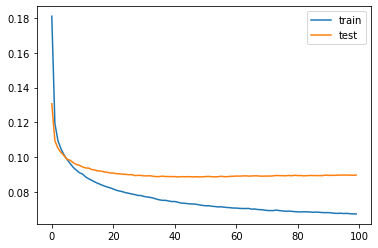

In [30]:
# fit network
history = model_supervised.fit(train_X_super, train_y, epochs=100, batch_size=16, 
                    validation_data=(test_X_super, test_y), verbose=0, shuffle=True)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

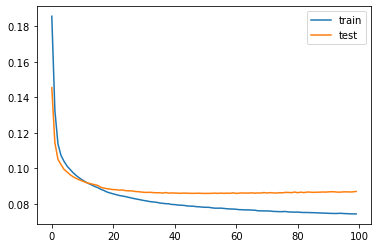

In [31]:
# fit network
history = model_sequential.fit(train_X_seq, train_y, epochs=100, batch_size=16, 
                    validation_data=(test_X_seq, test_y), verbose=0, shuffle=True)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Evaluate models

- This part doesn't work for `STEPS_OUT > 1`  
- Dummy predictor doesn't work for `STEPS_IN > 1` or `STEPS_OUT > 1`

But, both issues can be easily fixed (if needed).

In [32]:
train_inv_y = scaler.inverse_transform(train_y, **sparams)
test_inv_y = scaler.inverse_transform(test_y, **sparams)

### Dummy predictions

In [33]:
def dummy_prediction(train_X, type_, STEPS_IN, STEPS_OUT):    
    if STEPS_IN > 1 or STEPS_OUT > 1:
        raise NotImplementedError
    else:
        if type_ == 'super':
            return train_X
        elif type_ == 'seq':
            return np.squeeze(np.array(train_X)).T

In [34]:
train_ydummy_super = dummy_prediction(train_X_super, 'super', STEPS_IN, STEPS_OUT)
test_ydummy_super = dummy_prediction(test_X_super, 'super', STEPS_IN, STEPS_OUT)
train_inv_ydummy_super = scaler.inverse_transform(train_ydummy_super, **sparams)
test_inv_ydummy_super = scaler.inverse_transform(test_ydummy_super, **sparams)
rmse = np.sqrt(mean_squared_error(train_y, train_ydummy_super))
rmse_inv = np.sqrt(mean_squared_error(train_inv_y, train_inv_ydummy_super))
print(f"Train RMSE: {rmse} / {rmse_inv}")
rmse = np.sqrt(mean_squared_error(test_y, test_ydummy_super))
rmse_inv = np.sqrt(mean_squared_error(test_inv_y, test_inv_ydummy_super))
print(f"Test RMSE: {rmse} / {rmse_inv}")

Train RMSE: 0.18559815787406989 / 200.76360937596914
Test RMSE: 0.1843219799367409 / 197.81542070014837


In [35]:
train_ydummy_seq = dummy_prediction(train_X_seq, 'seq', STEPS_IN, STEPS_OUT)
test_ydummy_seq = dummy_prediction(test_X_seq, 'seq', STEPS_IN, STEPS_OUT)
train_inv_ydummy_seq = scaler.inverse_transform(train_ydummy_seq, **sparams)
test_inv_ydummy_seq = scaler.inverse_transform(test_ydummy_seq, **sparams)
rmse = np.sqrt(mean_squared_error(train_y, train_ydummy_seq))
rmse_inv = np.sqrt(mean_squared_error(train_inv_y, train_inv_ydummy_seq))
print(f"Train RMSE: {rmse} / {rmse_inv}")
rmse = np.sqrt(mean_squared_error(test_y, test_ydummy_seq))
rmse_inv = np.sqrt(mean_squared_error(test_inv_y, test_inv_ydummy_seq))
print(f"Test RMSE: {rmse} / {rmse_inv}")

Train RMSE: 0.18559815787406989 / 200.76360937596914
Test RMSE: 0.1843219799367409 / 197.81542070014837


### Models' predictions

In [36]:
train_yhat_super = model_supervised.predict(train_X_super)
test_yhat_super = model_supervised.predict(test_X_super)
train_inv_yhat_super = scaler.inverse_transform(train_yhat_super, **sparams)
test_inv_yhat_super = scaler.inverse_transform(test_yhat_super, **sparams)
rmse = np.sqrt(mean_squared_error(train_y, train_yhat_super))
rmse_inv = np.sqrt(mean_squared_error(train_inv_y, train_inv_yhat_super))
print(f"Train RMSE: {rmse} / {rmse_inv}")
rmse = np.sqrt(mean_squared_error(test_y, test_yhat_super))
rmse_inv = np.sqrt(mean_squared_error(test_inv_y, test_inv_yhat_super))
print(f"Test RMSE: {rmse} / {rmse_inv}")

Train RMSE: 0.16491847783811694 / 177.85143205529758
Test RMSE: 0.1862118774150082 / 267.20394832618643


In [37]:
train_yhat_seq = model_sequential.predict(train_X_seq)
test_yhat_seq = model_sequential.predict(test_X_seq)
train_inv_yhat_seq = scaler.inverse_transform(train_yhat_seq, **sparams)
test_inv_yhat_seq = scaler.inverse_transform(test_yhat_seq, **sparams)
rmse = np.sqrt(mean_squared_error(train_y, train_yhat_seq))
rmse_inv = np.sqrt(mean_squared_error(train_inv_y, train_inv_yhat_seq))
print(f"Train RMSE: {rmse} / {rmse_inv}")
rmse = np.sqrt(mean_squared_error(test_y, test_yhat_seq))
rmse_inv = np.sqrt(mean_squared_error(test_inv_y, test_inv_yhat_seq))
print(f"Test RMSE: {rmse} / {rmse_inv}")

Train RMSE: 0.17010963585940456 / 215.34695744799265
Test RMSE: 0.18023780089531463 / 248.07270267499234


In [38]:
def calculate_measures(true, pred):
    true = pd.DataFrame(true)
    pred = pd.DataFrame(pred)
    names = ["f1score", "spearman", "nrmse", "inter", "intra"]
    f1score = calculate_f1score(true, pred, return_scalar=True)
    spearman = calculate_spearman(true, pred, return_tuple=True)
    nrmse = calculate_nrmse(true, pred, return_tuple=True)
    inter = inter_dissimilarity(true, pred, return_scalar=True)
    _, _, intra = intra_dissimilarity(true, pred)
    return dict(zip(names, (f1score, spearman, nrmse, inter, intra)))

In [39]:
scores_train_dummy_super = calculate_measures(train_inv_y, train_inv_ydummy_super)
scores_test_dummy_super = calculate_measures(test_inv_y, test_inv_ydummy_super)
scores_train_dummy_seq = calculate_measures(train_inv_y, train_inv_ydummy_seq)
scores_test_dummy_seq = calculate_measures(test_inv_y, test_inv_ydummy_seq)

/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.5815970758806353 and the largest is 10.205728038774026.
  warn(
/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section fo

In [40]:
scores_train_super = calculate_measures(train_inv_y, train_inv_yhat_super)
scores_test_super = calculate_measures(test_inv_y, test_inv_yhat_super)
scores_train_seq = calculate_measures(train_inv_y, train_inv_yhat_seq)
scores_test_seq = calculate_measures(test_inv_y, test_inv_yhat_seq)

/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.5815970758806353 and the largest is 10.205728038774026.
  warn(
/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section fo

In [41]:
"Super, train:", scores_train_super, "Super, train (dummy):", scores_train_dummy_super

('Super, train:',
 {'f1score': 0.8419616383037347,
  'spearman': (0.6462347989198458, 80),
  'nrmse': (0.103000930663391, 0),
  'inter': 0.18868152072933145,
  'intra': 0.5500344219594949},
 'Super, train (dummy):',
 {'f1score': 0.8419974852949215,
  'spearman': (0.39643179798067985, 1),
  'nrmse': (0.1408902118573792, 0),
  'inter': 0.22846421230136263,
  'intra': 0.6797802476931127})

In [42]:
"Super, test:", scores_test_super, "Super, test (dummy):", scores_test_dummy_super

('Super, test:',
 {'f1score': 0.8305257498740545,
  'spearman': (0.3764515429996607, 84),
  'nrmse': (0.16592999487875035, 3),
  'inter': 0.30842670473680944,
  'intra': 0.6889696014263434},
 'Super, test (dummy):',
 {'f1score': 0.8440316795506774,
  'spearman': (0.3891525694264989, 25),
  'nrmse': (0.1886640748320393, 4),
  'inter': 0.23299523780129652,
  'intra': 0.5890496828149288})

In [43]:
"Seq, train:", scores_train_seq, "Seq, train (dummy):", scores_train_dummy_seq

('Seq, train:',
 {'f1score': 0.8468908339886578,
  'spearman': (0.5594430554136103, 73),
  'nrmse': (0.10995707593616895, 0),
  'inter': 0.23012927464308683,
  'intra': 0.662001387556882},
 'Seq, train (dummy):',
 {'f1score': 0.8419974852949215,
  'spearman': (0.39643179798067985, 1),
  'nrmse': (0.1408902118573792, 0),
  'inter': 0.22846421230136263,
  'intra': 0.6797802476931127})

In [44]:
"Seq, test:", scores_test_seq, "Seq, test (dummy):", scores_test_dummy_seq

('Seq, test:',
 {'f1score': 0.839285314063616,
  'spearman': (0.36574173539464894, 86),
  'nrmse': (0.15846535685268054, 1),
  'inter': 0.28860346153342853,
  'intra': 0.6619986390452899},
 'Seq, test (dummy):',
 {'f1score': 0.8440316795506774,
  'spearman': (0.3891525694264989, 25),
  'nrmse': (0.1886640748320393, 4),
  'inter': 0.23299523780129652,
  'intra': 0.5890496828149288})

In [45]:
def plot_series(train_true, train_pred, train_dummy, test_true, test_pred, test_dummy, group):
    if train_true is not None and train_pred is not None:
        plt.figure(figsize=(15,5))
        plt.subplot(1, 2, 1)
        plt.plot(train_true[:, group-1], label='true')
        plt.plot(train_pred[:, group-1], label='predicted')
        if train_dummy is not None:
            plt.plot(train_dummy[:, group-1], label='dummy')
        # pyplot.plot(abs(test_inv_yhat_super[:, group-1] - test_inv_y[:, group-1]))  # absolute difference
        rmse = np.sqrt(mean_squared_error(train_true[:, group-1], train_pred[:, group-1]))
        plt.title(f'Train, {group}, {rmse:.3f}')
        plt.legend()
        plt.subplot(1, 2, 2)
    plt.plot(test_true[:, group-1], label='true')
    plt.plot(test_pred[:, group-1], label='predicted')
    if train_dummy is not None:
        plt.plot(test_dummy[:, group-1], label='dummy')
    # pyplot.plot(abs(test_inv_yhat_super[:, group-1] - test_inv_y[:, group-1]))  # absolute difference
    rmse = np.sqrt(mean_squared_error(test_true[:, group-1], test_pred[:, group-1]))
    plt.title(f'Test, {group}, {rmse:.3f}')
    plt.legend()
    plt.show()

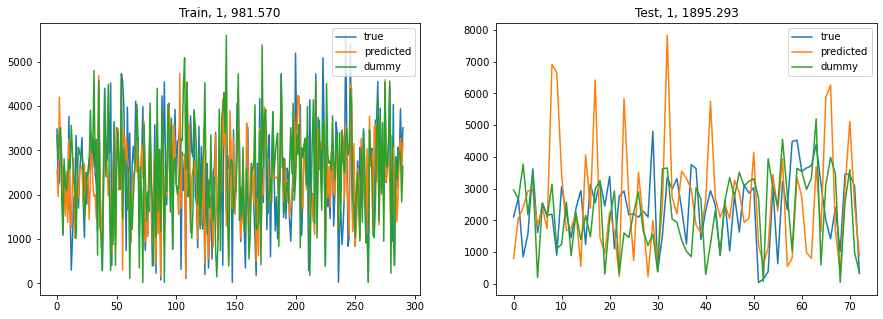

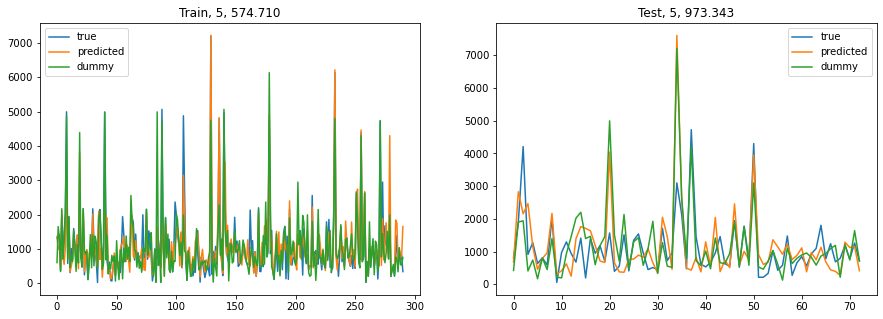

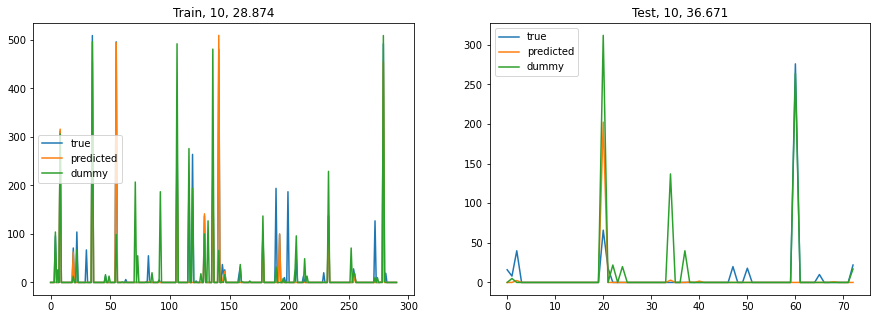

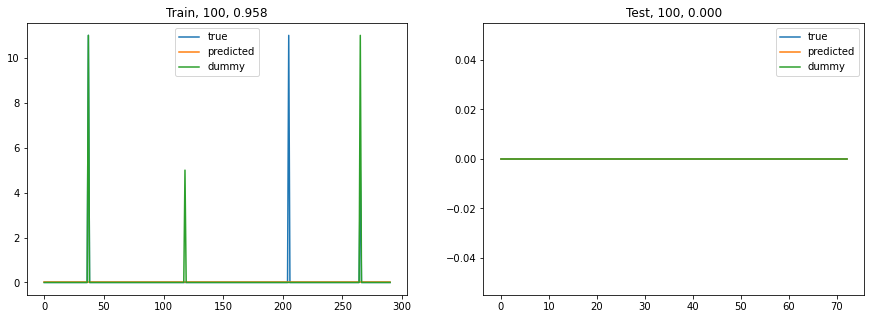

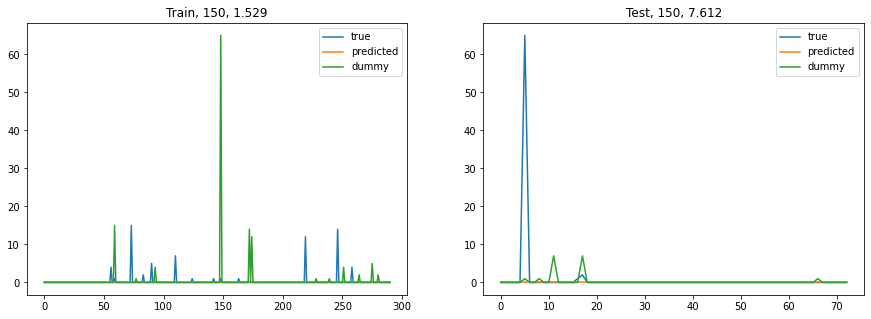

In [46]:
for group in [1, 5, 10, 100, 150]:
    plot_series(train_inv_y, train_inv_yhat_super, train_inv_ydummy_super, test_inv_y, test_inv_yhat_super, test_inv_ydummy_super, group)

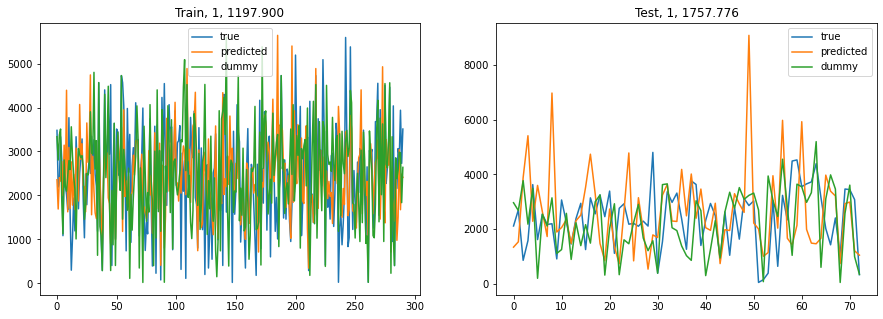

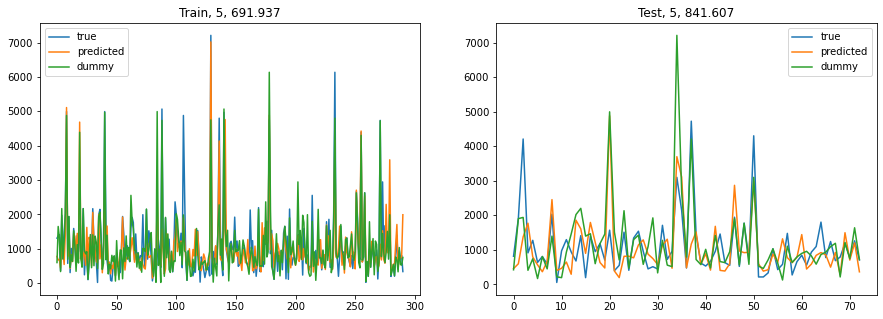

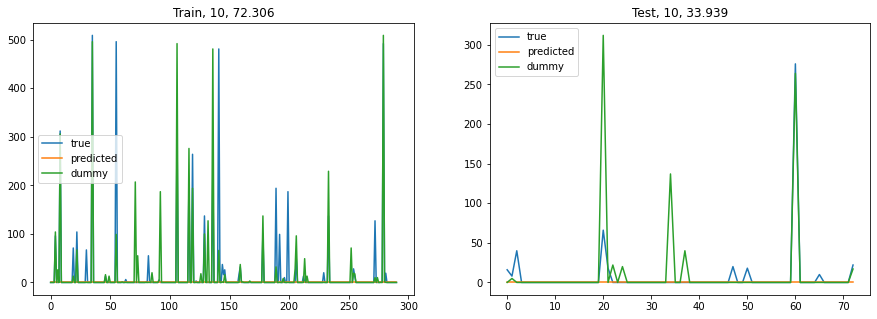

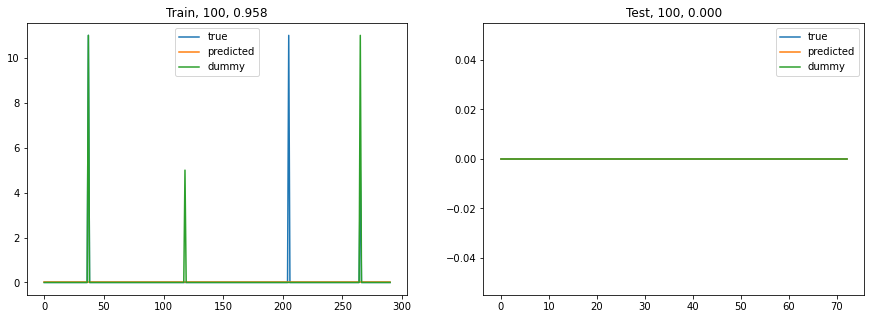

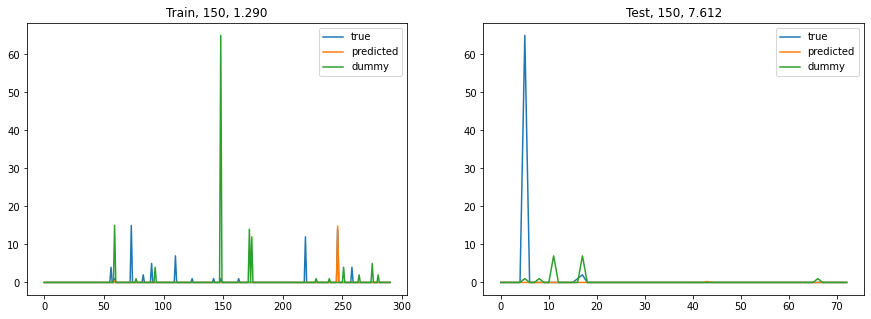

In [47]:
for group in [1, 5, 10, 100, 150]:
    plot_series(train_inv_y, train_inv_yhat_seq, train_inv_ydummy_seq, test_inv_y, test_inv_yhat_seq, test_inv_ydummy_seq, group)

## Test on reference dataset

In [48]:
ref_dataset =  pd.DataFrame(scaler.transform(ref_dataset_original), 
                            columns=ref_dataset_original.columns, 
                            index=ref_dataset_original.index)
ref_reframed = series_to_supervised(ref_dataset.values, STEPS_IN, STEPS_OUT)

In [49]:
ref_X, ref_y, _, _ = split_reframed(ref_reframed, 1, STEPS_IN, shuffle=False)

(252, 1, 166) (252, 166) (0, 1, 166) (0, 166)


In [50]:
ref_X_seq, _ = prepare_sequential_data(ref_X)
ref_X_super, _ = prepare_supervised_data(ref_X)

In [51]:
ref_yhat_super = model_supervised.predict(ref_X_super)
ref_yhat_seq = model_sequential.predict(ref_X_seq)

In [52]:
ref_inv_y = scaler.inverse_transform(ref_y, **sparams)
ref_inv_yhat_super = scaler.inverse_transform(ref_yhat_super, **sparams)
ref_inv_yhat_seq = scaler.inverse_transform(ref_yhat_seq, **sparams)

In [53]:
scores_ref_super = calculate_measures(ref_inv_y, ref_inv_yhat_super)
scores_ref_seq = calculate_measures(ref_inv_y, ref_inv_yhat_seq)

/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.41503665898622627 and the largest is 11.788692284751429.
  warn(
/home/MCB/pszczerbiak/miniconda3/envs/keras/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section f

In [54]:
"Super, ref:", scores_ref_super

('Super, ref:',
 {'f1score': 0.5447404264787665,
  'spearman': (0.17866779236419666, 3),
  'nrmse': (64.86712890452127, 0),
  'inter': 0.7888120726946358,
  'intra': 0.7317683080390984})

In [55]:
"Seq, ref:", scores_ref_seq

('Seq, ref:',
 {'f1score': 0.5952547877685368,
  'spearman': (0.20948824231349233, 14),
  'nrmse': (34.31060759923357, 0),
  'inter': 0.6645333797978145,
  'intra': 0.7038890289865805})

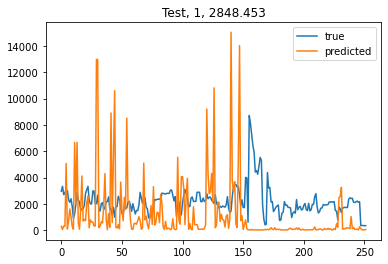

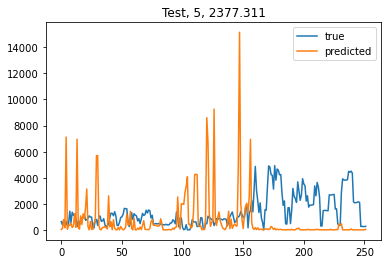

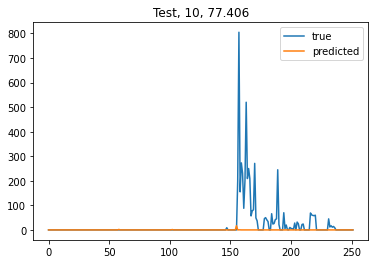

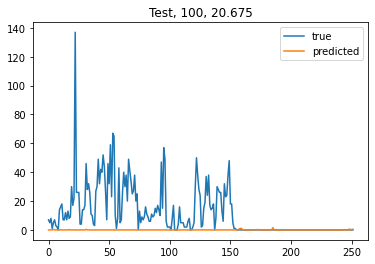

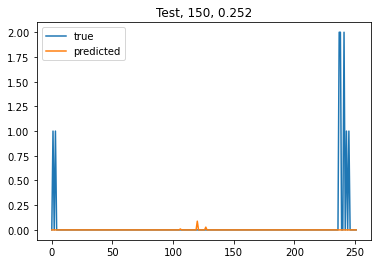

In [56]:
for group in [1, 5, 10, 100, 150]:
    plot_series(None, None, None, ref_inv_y, ref_inv_yhat_super, None, group)

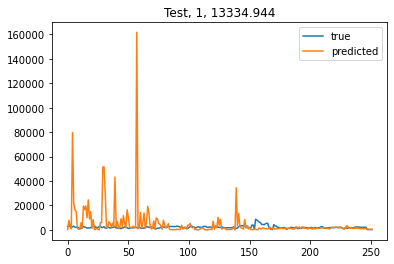

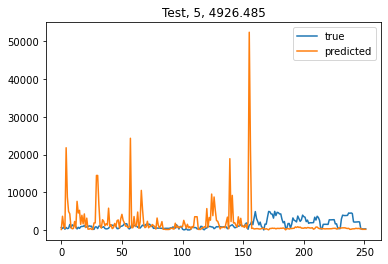

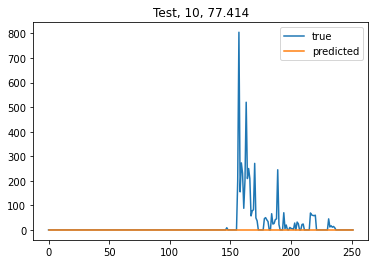

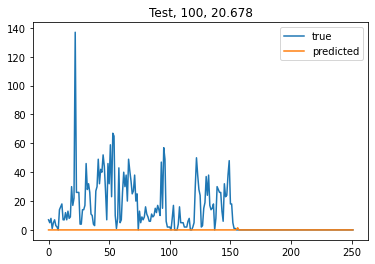

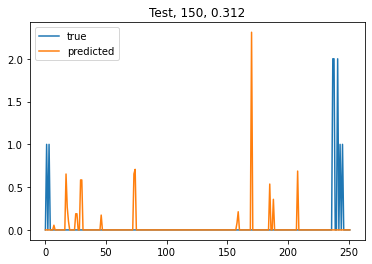

In [57]:
for group in [1, 5, 10, 100, 150]:
    plot_series(None, None, None, ref_inv_y, ref_inv_yhat_seq, None, group)